In [1]:
# imports
import sys
sys.path.append("/home/kitouni/MoDe/")
from mode_tf import MoDeLoss
from time import time
import numpy as np
from matplotlib import pyplot as plt
import keras
import tensorflow as tf

plt.style.use("dark_paper")
def get_lin_mass(a=.5,b=.5,n=int(5e5/2),umin=0,umax=1):
    u = np.random.uniform(umin,umax,n)
    return - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
def find_threshold(L,mask,x_frac):
    """
    Calculate c such that x_frac of the array is less than c.

    Parameters
    ----------
    L : Array
        The array where the cutoff is to be found
    mask : Array,
        Mask that returns L[mask] the part of the original array over which it is desired to calculate the threshold.
    x_frac : float
        Of the area that is lass than or equal to c.

    returns c (type=L.dtype)
    """
    max_x = mask.sum()
    x = int(np.round(x_frac * max_x))
    L_sorted = np.sort(L[mask.astype(bool)])
    return L_sorted[x]
def make_plot(model_legendre,Y,validation_predictions,bins=50,title="DNN"):  
    cuts = []
    efficiencies = np.linspace(0.1,0.9,9)[::-1]
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
    scores = model_legendre(Y,training=False).numpy().flatten()

    R50 = 1/((scores[y_test==1]<cuts[4]).sum()/(y_test==1).sum())

    sorted_m = np.argsort(m_t)
    m = m_t[sorted_m].reshape(bins,-1).mean(axis=1)
    scores = scores[sorted_m].reshape(bins,-1)

    fig, ax  = plt.subplots(1,1,figsize=[8,5],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax.set_ylabel(r"False Pos. Rate",fontsize=17)
    ax.text(-0.75,0.9,f"R50:{R50:.1f}",fontsize=17)
    ax.set_ylim([-0.02,1.02])
    ax.set_title(title, fontsize=17)
    ax.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)
    ax.set_xlabel(r"$m$",fontsize=19)

    fig.tight_layout(pad=0)
    plt.show()
    return

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


<ShuffleDataset shapes: ((2,), (1,), (1,)), types: (tf.float32, tf.float32, tf.float32)>

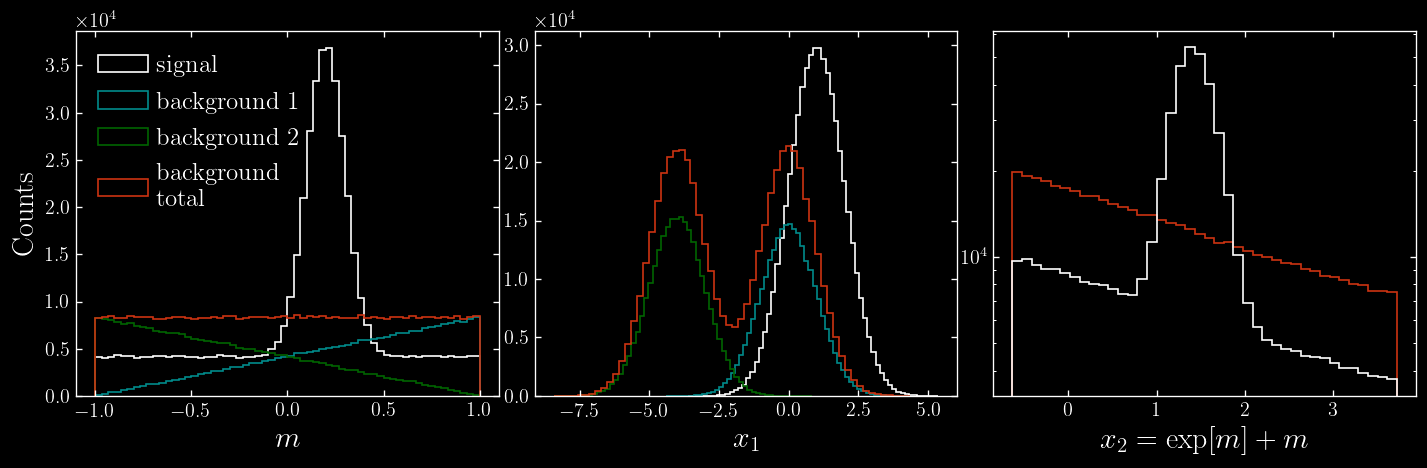

In [2]:
# data
np.random.seed(42)
n_s = int(5e5)
n_b = int(5e5/2)
n_s_gauss_frac = 0.5

m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.2,0.1,size=int(n_s_gauss_frac*n_s))])
m_b1 = get_lin_mass(.5,.5,n_b)
m_b2=  get_lin_mass(-.5,.5,n_b)
m_b = np.concatenate([m_b1,m_b2])
m_t1 = get_lin_mass(.5,.5,n_b)
m_t2=  get_lin_mass(-.5,.5,n_b)
m_t  = np.concatenate([m_t1,m_t2])

x1_b1 = np.random.normal(0,1,n_b)
x1_b2 = np.random.normal(-4,1,n_b)
x1_b  = np.concatenate([x1_b1,x1_b2])
x1_s  = np.random.normal(1,1,n_s)
x1_t  = np.concatenate([np.random.normal(0,1,n_b),np.random.normal(-4,1,n_b)])

x2_s = np.exp(m_s)+m_s
x2_b = np.exp(m_b)+m_b
x2_t = np.exp(m_t)+m_t

fig ,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12,4),dpi=120,sharey=False)

_,bins,_ = ax1.hist(m_s,bins=60,density=False,alpha=1,label='signal',histtype="step",color='w')
ax1.hist(m_b1,bins=bins,density=False,label='background 1',histtype="step",color='darkcyan',alpha=1)
ax1.hist(m_b2,bins=bins,density=False,label='background 2',histtype="step",color='darkgreen',alpha=1)
ax1.hist(m_b,bins=bins,density=False,alpha=1,label='background\n total',histtype="step",color='C2')
ax1.legend(loc="upper left",fontsize=15,handletextpad=0.3)
ax1.set_xlabel(r"$m$",fontsize=18)
ax1.set_ylabel("Counts",fontsize=18)
#ax1.set_ylim([0,3.6e4])
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax2.hist(x1_s,bins=60,density=False,alpha=1,label='signal',color='w',histtype='step')
ax2.hist(x1_b1,bins=60,density=False,label='background 1',color='darkcyan',histtype="step",alpha=1)
ax2.hist(x1_b2,bins=60,density=False,label='background 2',color='darkgreen',histtype="step",alpha=1)
ax2.hist(x1_b,bins=60,density=False,alpha=1, label='background total',histtype="step",color="C2")
ax2.set_xlabel(r"$x_1$",fontsize=18)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

_,bins,_ = ax3.hist(x2_b,bins=40,density=False,alpha=1, label='background',histtype="step",color="C2")
ax3.hist(x2_s,bins=bins,density=False,alpha=1,label='signal',histtype="step",color='w')
ax3.set_xlabel(r"$x_2=\exp[m]+m$",fontsize=18)
ax3.set_yscale("log")
fig.tight_layout(w_pad=0.2)
##############################################finalize 
x = np.concatenate([np.stack([m_s,x1_s,x2_s],axis=1),
                   np.stack([m_b,x1_b,x2_b],axis=1)]).astype("float32") 
y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)]).astype("float32") 

x_test = np.stack([m_t,x1_t,x2_t],axis=1).astype("float32") 
y_test = np.ones(x_test.shape[0])
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train[:,1:],
                                                    y_train.reshape(-1,1),
                                                    x_train[:,0].reshape(-1,1)))
train_dataset.shuffle(len(x_train),seed=0)

In [3]:
def grad(model, x, y,x_biased,loss):
    with tf.GradientTape() as tape:
        y_ = model(x,training=True)
        loss_value = loss(y_,y,x_biased)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)
class Model(keras.Model):
    def __init__(self,name=None):
        super().__init__()
        self.linear = tf.keras.layers.Dense(16, input_shape=[2], activation='relu')
        self.linear1 = tf.keras.layers.Dense(32,activation='relu')
        self.linear2 = tf.keras.layers.Dense(64,activation='relu')
        self.linear3 = tf.keras.layers.Dense(64,activation='relu')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Dense(1,activation='sigmoid')
    def call(self, x):
        x = self.linear(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.batchnorm(x)
        x = self.out(x)
        return x
    def _fit(self,train_dataset,batch_size=2**14,loss=None, epochs=10,verbose=10,
             optimizer=None):
        if loss is None:
            loss = lambda pred,target,x_biased: tf.reduce_mean((target-pred)**2)
        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam(lr=1e-2)
        num_samples =  tf.data.experimental.cardinality(train_dataset).numpy()
        pb = tf.keras.utils.Progbar(num_samples//batch_size*epochs, width=30, verbose=1, interval=0.1, stateful_metrics=["acc"],unit_name='step')
        for epoch in range(epochs):
            #print("\nepoch {}/{}".format(epoch+1,epochs))
            epoch_loss_avg = tf.keras.metrics.Mean()
            epoch_accuracy = tf.keras.metrics.Accuracy()
            t0 = time()
            for idx, (x, y,m) in enumerate(train_dataset.batch(batch_size)):
            # Optimize the model
                loss_value, grads = grad(model, x, y,m,loss)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                # Track progress
                epoch_loss_avg.update_state(loss_value)
                epoch_accuracy.update_state(y_pred=tf.round(model(x, training=False)),y_true=y)
                pb.update(idx+num_samples//batch_size*epoch,values=[("loss", epoch_loss_avg.result()),('acc',epoch_accuracy.result())])

In [4]:
params = {"epochs":10,"batch_size":2**14,"verbose":10}

480/480 [==============================] - 31s 64ms/step - loss: 0.1171 - acc: 0.8345


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


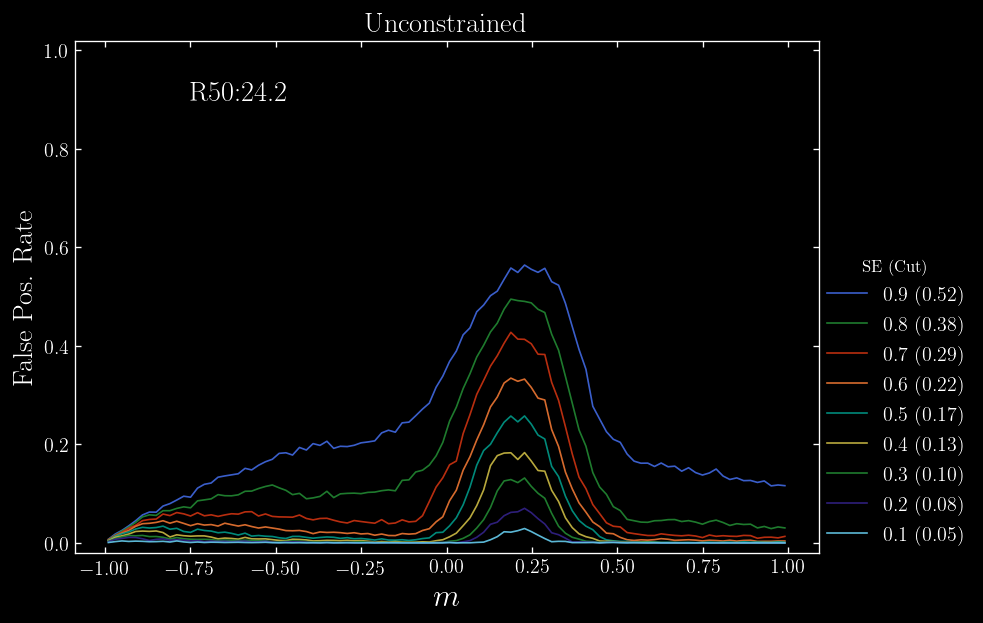

In [5]:
# Unconstrained no MoDe loss
models = list()
bins = 25
for order in [0]:
    tf.random.set_seed(777)
    loss= lambda pred,target,x_biased: tf.reduce_mean((target-pred)**2)
    model = Model()
    model._fit(train_dataset,loss=loss,**params)
    models.append(model)
    title = r"Unconstrained"
    make_plot(model,Y=x_test[:,1:],validation_predictions=model(x_val[:,1:],training=False).numpy().flatten(),
                   title=title,
                   bins=100)

Instructions for updating:
Use tf.identity instead.
480/480 [==============================] - 73s 152ms/step - loss: 0.3141 - acc: 0.7699


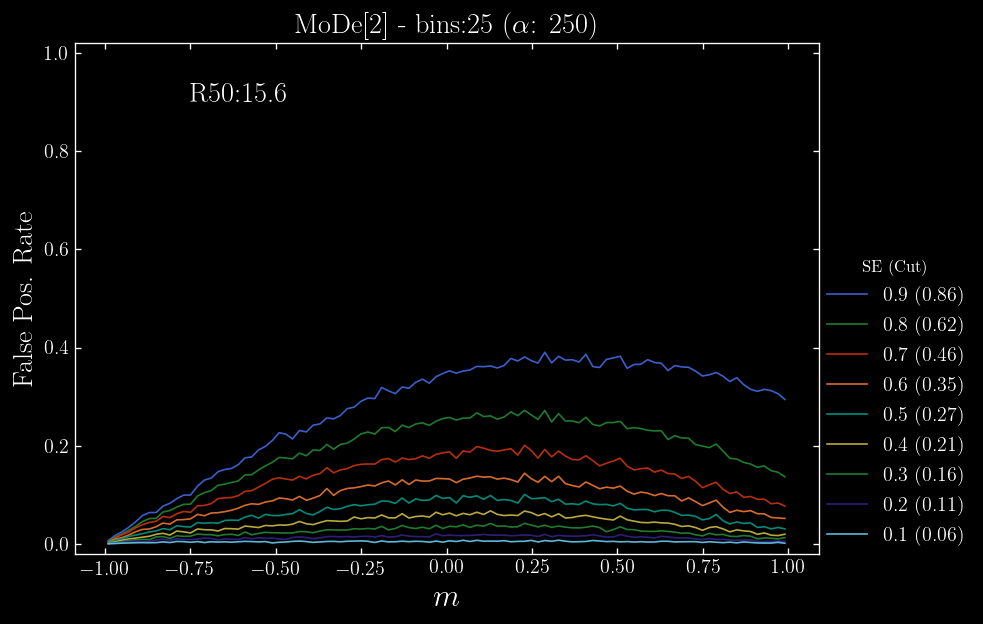

480/480 [==============================] - 73s 151ms/step - loss: 0.3774 - acc: 0.7516


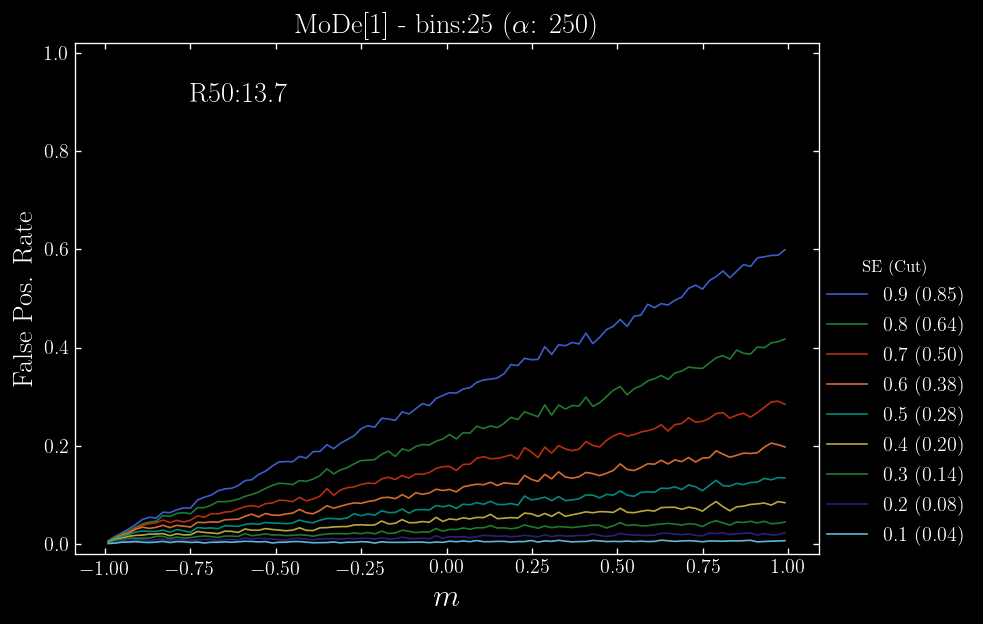

2400/2400 [==============================] - 369s 154ms/step - loss: 0.3949 - acc: 0.7328


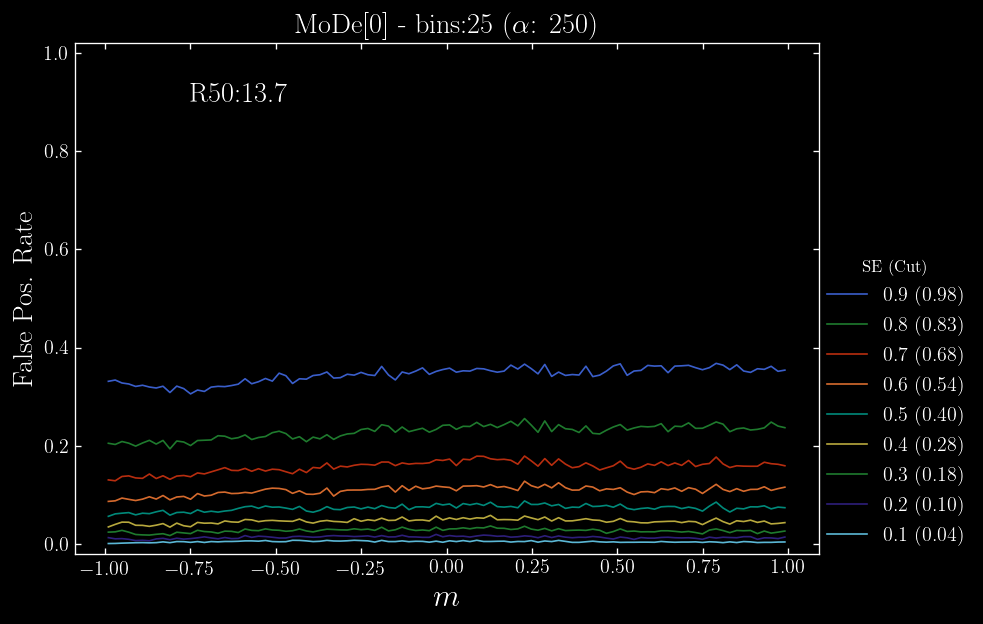

In [6]:
# MoDe[2],MoDe[1],MoDe[0]
bins = 25
alpha = 250
for order in [2,1,0]:
    if order==0: params["epochs"] = 50
    tf.random.set_seed(777)
    MoDe = MoDeLoss(bins=bins,order=order,dynamicbins=True,background_label=1,
                                   #max_slope=slope,eps=1e-5, monotonic=True,
                                  background_only=True,normalize=False)
    loss= lambda pred,target,x_biased: tf.reduce_mean((target-pred)**2) + alpha * MoDe(pred,target,x_biased,)
    model = Model()
    model._fit(train_dataset,loss=loss,**params)
    models.append(model)
    title = r"MoDe[{:d}] - bins:{:d} ($\alpha$: {:d})"
    make_plot(model,Y=x_test[:,1:],validation_predictions=model(x_val[:,1:],training=False).numpy().flatten(),
                   title=title.format(order,bins,alpha),
                   bins=100)